[0.  0.4 0.  0. ]
(4, 4) (4, 1)
A matrix free vars: set() 
B matrix free vars: set()
{x(t): 1, Derivative(x(t), t): 0, Derivative(x(t), (t, 2)): 0, theta0(t): 0, Derivative(theta0(t), t): 0, Derivative(theta0(t), (t, 2)): 0}


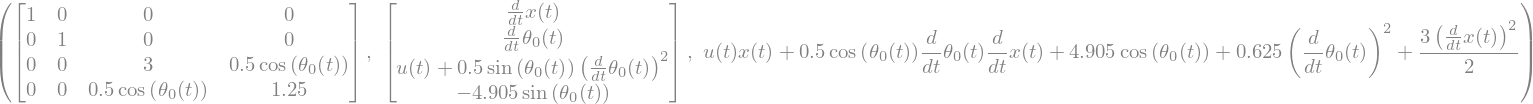

In [21]:
import sympy
import numpy as np
import scipy
from scipy import integrate
import matplotlib.pyplot as plt
from sympy.physics import vector
from sympy.physics import mechanics
from matplotlib import animation
import matplotlib


plt.style.use('seaborn')
matplotlib.rcParams["figure.figsize"] = (10.0, 10.0)
sympy.init_printing(use_latex=True)

n = 1
g = sympy.symbols("g")
x = mechanics.dynamicsymbols("x")
xd = mechanics.dynamicsymbols("x", 1)
xdd = mechanics.dynamicsymbols("x", 2)
theta = mechanics.dynamicsymbols("theta:"+ str(n))
thetad = mechanics.dynamicsymbols("theta:" + str(n), 1)
thetadd = mechanics.dynamicsymbols("theta:" + str(n), 2)

lengths = sympy.symbols("l:" + str(n))
masses = sympy.symbols("m:" + str(n))
m_top = sympy.symbols("m_{top}")
radii = sympy.symbols("r:" + str(n))
inertia_vals = sympy.symbols("I:" + str(n))

values = {g: 9.81, m_top: 2}
o_point = {x: 1, xd: 0, xdd: 0}
x0 = np.zeros(n * 2 + 2) 
x0[1:n+1] = .4
#x0 = np.array([0.4,0,0,0])

print(x0)

for i in range(n):
    o_point.update({theta[i]: 0, thetad[i]: 0, thetadd[i]: 0})
    values.update({lengths[i]: 1, masses[i]: 1})
    values.update({radii[i]: .5, inertia_vals[i]: 1})
lengthsum = sum([values[i] for i in lengths])

u = mechanics.dynamicsymbols("u")

T = []
U = []

N = mechanics.ReferenceFrame("N")
P = mechanics.Point("P")
P.set_vel(N, 0)

PIv = N.y * xd
PIp = N.y * x
PI = P.locatenew("PI",PIp)
PI.set_vel(N, PIv) 
top_pivot = mechanics.Particle('top_pivot', PI, m_top)
T.append(top_pivot.kinetic_energy(N))

pivot0_frame = mechanics.ReferenceFrame("pivot0_f")
pivot0_frame.orient(N, "Axis", [ theta[0], N.z])
pivot0_frame.set_ang_vel(N, ( thetad[0]* N.z))


pivot0 = PI.locatenew("pivot0", lengths[0] * pivot0_frame.x)
pivot0.v2pt_theory(PI, N, pivot0_frame)

com0 = PI.locatenew("com0", radii[0] * pivot0_frame.x)
com0.v2pt_theory(PI, N, pivot0_frame)

inertai_dyad = vector.outer(pivot0_frame.z, pivot0_frame.z) * inertia_vals[0]
body = mechanics.RigidBody("B", com0, pivot0_frame, masses[0], (inertai_dyad, com0))

U.append(com0.pos_from(P).dot(N.x) * masses[0] * -g)
T.append(body.kinetic_energy(N))


pivot_prev = pivot0

for i in range(1,n):
    P_f = mechanics.ReferenceFrame("P_f")
    P_f.orient(N, "Axis", [theta[i], N.z])
    P_f.set_ang_vel(N, thetad[i] * N.z)

    pivot = mechanics.Point("p")
    pivot.set_pos(pivot_prev, lengths[i] * P_f.x)
    pivot.v2pt_theory(pivot_prev, N, P_f)

    com = mechanics.Point("com")
    com.set_pos(pivot_prev, radii[i] * P_f.x)
    com.v2pt_theory(pivot_prev, N, P_f)

    inertai_dyad = vector.outer(P_f.z, P_f.z) * inertia_vals[i]
    body = mechanics.RigidBody("B", com, P_f, masses[i], (inertai_dyad, com))

    U.append(com.pos_from(P).dot(N.x) * masses[i] * -g)
    T.append(body.kinetic_energy(N))

    pivot_prev = pivot

L = sum(T) - sum(U) + x * u
L = sympy.simplify(L).subs(values)

Lagrangian = mechanics.LagrangesMethod(L, [x] + theta)
Lagrangian.form_lagranges_equations()

M = Lagrangian.mass_matrix_full
K = Lagrangian.forcing_full

print(M.shape,K.shape)

M_lambd, K_lambd = sympy.lambdify(tuple([x] + theta + [xd] + thetad + [u]), M), sympy.lambdify(tuple([x] + theta + [xd] + thetad + [u]), K)

A, B, inp = Lagrangian.linearize(q_ind=[x]+theta, qd_ind=[xd]+thetad, A_and_B=True, op_point = o_point)

print("A matrix free vars: {} ".format(A.free_symbols))
print("B matrix free vars: {}".format(B.free_symbols))
print(o_point)
sympy.simplify(M), sympy.simplify(K), L

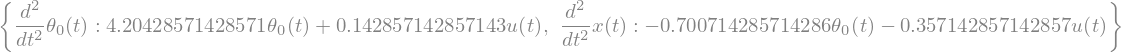

In [4]:
def linear_nd_taylor(f, x0):
    linear_term = sympy.zeros(*f.shape)
    for var in x0.keys():
        linear_term += (sympy.diff(f, var).subs(x0)) * (var - x0[var])
    return f.subs(x0) + linear_term 
klin = linear_nd_taylor(K, o_point)
mlin = linear_nd_taylor(M, o_point)
xdd_dict = sympy.solve(mlin @ sympy.Matrix([xd] + thetad + [xdd] + thetadd) + klin, sympy.Matrix([xdd] + thetadd))
xdd_dict

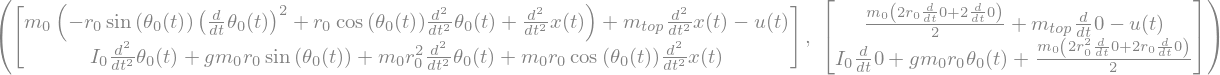

In [78]:
sympy.simplify(Lagrangian.eom), linear_nd_taylor(Lagrangian.eom, o_point)

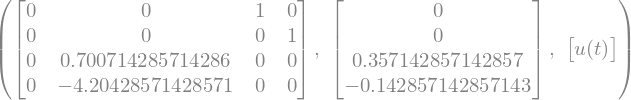

In [22]:
A, B, inp